In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/ABIDE/") 

Mounted at /content/drive


In [ ]:
# load ComBat algorithm
# !python /content/drive/MyDrive/ABIDE/neuralCombat.py 
import sys
sys.path.append('/content/drive/MyDrive/ABIDE/')

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from neuralCombat import *
# from neuralCombat.py import neuralCombat
import pandas as pd
from sklearn import svm
import joblib
import openpyxl
from openpyxl import load_workbook
import os
import scipy.io as scio
import argparse
import numpy as np
import time
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
import torchvision.utils as vutils
from os.path import join
from os import listdir
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import DataLoader
from collections import OrderedDict
import nibabel as nib
import matplotlib.pyplot as plt
import cv2 as cv
from os import path
import shutil
import scipy.stats
import scipy.ndimage
import random
import torch.nn.init as init
import torch.nn.functional as F
import sys
import math
from functools import reduce
import operator
from scipy.interpolate import interp1d
from torch.optim import lr_scheduler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import RFE

def feature_selection(matrix, labels, train_ind, fnum):
    """
        matrix       : feature matrix (num_subjects x num_features)
        labels       : ground truth labels (num_subjects x 1)
        train_ind    : indices of the training samples
        fnum         : size of the feature vector after feature selection 

    return:
        x_data      : feature matrix of lower dimension (num_subjects x fnum)
    """

    estimator = RidgeClassifier()
    selector = RFE(estimator, n_features_to_select=fnum, step=100, verbose=1)

    featureX = matrix[train_ind, :]
    featureY = labels[train_ind]
    selector = selector.fit(featureX, featureY.ravel())

    return selector

def get_index(lst=None, item=''):
	return [i for i in range(len(lst)) if lst[i] == item]

def flatten_one(length, img):
	'''
	  In some situations, the dimension on z-axis of images are smaller than
	  the dimension of z-axis of patches, this function will be used to pad
	'''

	one_line = np.zeros((1, int(length)))
	position = 0
	for i in range(img.shape[0]):  # column
		for j in range(i + 1, img.shape[1]):  # row
			one_line[0, position] = img[j, i]
			position = position + 1
	return one_line


def get_ids(num_subjects=None,dir_path=''):
	"""
	return:
		subject_IDs    : list of all subject IDs
	"""
	subject_IDs = np.genfromtxt(os.path.join(dir_path, 'subject_IDs.txt'), dtype=str)

	if num_subjects is not None:
		subject_IDs = subject_IDs[:num_subjects]

	return subject_IDs

def save_model(net,path, name_net):

  # This fucntion is used to save a specific model

    path_net =  path + '/' + name_net + '.pth'
    torch.save(net.cpu().state_dict(), path_net)
    net.cuda()

def load_model(net, path, name_net):

  # This function is used to load a specific model we saved before

    path_net =  path + '/' + name_net + '.pth'
    net.load_state_dict(torch.load(path_net))

    return net

def initialize():
  set_seed


def set_seed(seed=0):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# initialize()

In [ ]:
########################################### Load Data ###############################################
#####################################################################################################
#####################################################################################################
fMRI_atlas = 'CC200'  # AAL or CC200
combat = True    # True or False
scaler = True

if combat == False:
  save_combat = '/without_ComBat/'
else:
  save_combat = '/with_ComBat/'

save_path = '/content/drive/MyDrive/ABIDE/save_models/'+fMRI_atlas+ save_combat
root_path = '/content/dataset'
if os.path.exists(root_path):
  shutil.rmtree(root_path) 
shutil.copytree('/content/drive/MyDrive/ABIDE/' + fMRI_atlas + '/original/', root_path) 
label_dir = '/content/drive/MyDrive/ABIDE/phenotypic_image_quality'

k_fold = 5
new_number_features = 5000
number_samples = 871
useless_samples = ['51334']
if fMRI_atlas == 'AAL':
  image_size = [116, 116]
else:
  image_size = [200, 200]


age_name = 'ages.mat'
gender_name = 'genders.mat'
label_name = 'ABIDE_label_871.mat'
label = scio.loadmat(os.path.join(label_dir, label_name))
label = label['label'][0]
labels = np.zeros(number_samples - len(useless_samples))
site_name = 'sites.mat'
site = scio.loadmat(os.path.join(label_dir, site_name))
all_sites = site['sites']
for i in range(len(all_sites)):
	site = all_sites[i]
	all_sites[i] = site.replace(' ', '')
unique_sites = np.unique(all_sites)
sites = []
unique_sites = list(unique_sites)

gender = scio.loadmat(os.path.join(label_dir, gender_name))
gender = gender['genders']
genders = np.zeros((number_samples - len(useless_samples), 1))

age = scio.loadmat(os.path.join(label_dir, age_name))
age = age['ages']
ages = np.zeros((number_samples - len(useless_samples), 1))

subject_IDs = get_ids(number_samples,dir_path=label_dir)
subject_IDs = subject_IDs.tolist()
length = image_size[0] * (image_size[1]-1) / 2
fMRI_images = np.zeros((number_samples - len(useless_samples), int(length)))

position = 0
print('constructing fMRI features')
for i in range(number_samples):
  subject_name = subject_IDs[i]
  print(subject_name)
  if subject_name in useless_samples:
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    print('The index for sample ' + subject_name + ' is : ', subject_index)
  else:
    image_name = subject_name + '.mat'
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    image = scio.loadmat(os.path.join(root_path, image_name))
    img = image['connectivity']

    idx = np.triu_indices_from(img, 1)
    fMRI_images[position, :] = img[idx]
    sites.append(all_sites[subject_index[0]])
    labels[position] = label[subject_index[0]]
    genders[position] = int(gender[subject_index[0]]) + 1
    ages[position] = float(age[subject_index[0]].replace(' ', ''))
    position = position + 1
if scaler == True:
	fMRI_images = StandardScaler().fit_transform(fMRI_images)
	print('Done')

constructing fMRI features
50003
50004
50005
50006
50007
50008
50010
50011
50012
50013
50014
50015
50016
50020
50022
50023
50024
50025
50026
50027
50028
50030
50031
50032
50033
50034
50035
50036
50037
50038
50039
50040
50041
50042
50043
50044
50045
50046
50047
50048
50049
50050
50051
50052
50053
50054
50056
50057
50059
50060
50102
50103
50104
50105
50106
50107
50109
50111
50112
50113
50114
50115
50116
50117
50118
50119
50121
50123
50124
50125
50127
50128
50129
50130
50131
50132
50134
50135
50142
50143
50144
50145
50146
50147
50148
50149
50150
50152
50153
50156
50157
50158
50159
50160
50161
50162
50163
50164
50167
50168
50169
50170
50171
50182
50183
50184
50186
50187
50188
50189
50190
50193
50194
50195
50196
50198
50199
50200
50201
50202
50203
50204
50205
50206
50208
50210
50213
50214
50215
50217
50232
50233
50234
50236
50237
50239
50240
50241
50243
50245
50247
50248
50249
50250
50251
50252
50253
50254
50255
50257
50259
50260
50261
50262
50263
50264
50265
50266
50267
50268
50269
50270
5

In [ ]:
############################################### Combat ###############################################################
############################################### Combat ###############################################################
############################################### Combat ###############################################################
if combat == True:
	batch = []
	for i in range(len(sites)):
		batch.append(get_index(lst=unique_sites, item=sites[i])[0]+1)

	combat_labels = []
	combat_genders = []
	combat_ages = []
	for i in range(len(labels)):
		combat_labels.append(labels[i] + 1)
		combat_genders.append(genders[i])
		combat_ages.append(ages[i])

	new_all_samples_feature = fMRI_images.T
	covars = {}
	covars['batch'] = batch
	covars['labels'] = combat_labels
	covars['genders'] = combat_genders
	covars['ages'] = combat_ages
	covars = pd.DataFrame(covars)

	# To specify names of the variables that are categorical:
	categorical_cols = ['labels', 'genders']
	# To specify the name of the variable that encodes for the scanner/batch covariate:
	batch_col = 'batch'
	continuous_cols = ['ages']
	# Harmonization step:
	new_all_samples_feature = neuroCombat(dat=new_all_samples_feature,
										  covars=covars,
										  batch_col=batch_col,
										  categorical_cols=categorical_cols,
											continuous_cols=continuous_cols)["data"]
	fMRI_images = new_all_samples_feature.T

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


In [ ]:
dist_train = {}
dist_validation = {}
dist_test = {}
for i in range(k_fold):
	dist_train[str(i + 1)] = []
	dist_validation[str(i + 1)] = []
	dist_test[str(i + 1)] = []

for each_site in unique_sites:
	index_site = get_index(sites, each_site)
	label = np.zeros((len(index_site)))
	for i in range(len(index_site)):
		index = index_site[i]
		label[i] = int(labels[int(index)])
	########################################### StratifiedKFold ####################################################
	sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
	group = 0
	for train, validation in sfolder.split(index_site,label):
		for i in train:
			dist_train[str(group + 1)].append(index_site[i])
			name = 0
		for j in validation:
			dist_validation[str(group + 1)].append(index_site[j])
			name = 0
		group = group+1

	group = 0
	for train, validation in sfolder.split(index_site,label):
		if group == 0:
			for j in validation:
				dist_test[str(group + k_fold)].append(index_site[j])
				dist_train[str(group + k_fold)].remove(index_site[j])
		else:
			for j in validation:
				dist_test[str(group)].append(index_site[j])
				dist_train[str(group)].remove(index_site[j])
		group = group+1

In [ ]:
import torch.nn as nn
############################################### FCN model ###############################################################
############################################### FCN model ###############################################################
############################################### FCN model ###############################################################
def single_linear(in_channels, out_channels, dropout):
    return nn.Sequential(
        nn.Linear(in_features=in_channels, out_features=out_channels),
        nn.Dropout(dropout),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(out_channels)
    )

class FCN(nn.Module):
    def __init__(self, input_c, hid_1, hid_2, out_c, dropout):
        super().__init__()

        self.linear_1 = single_linear(input_c, hid_1, dropout)
        self.linear_2 = nn.Linear(in_features=hid_1, out_features=hid_2)
        self.linear_3 = nn.Linear(in_features=hid_2, out_features=out_c)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU(inplace=True)
        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, x):

        input = torch.flatten(x, start_dim=1, end_dim=-1)
        x = self.relu(self.linear_1(input))
        x = self.relu(self.dropout(self.linear_2(x)))
        x = self.linear_3(x)
        out = self.softmax(x)
        return out

In [ ]:
FCN_labels = np.zeros((number_samples - len(useless_samples), 2))
for i in range(len(labels)):
    if labels[i] == 1:
        FCN_labels[i,0] = 1
    else:
        FCN_labels[i,1] = 1

data = {}
for fold in range(1, k_fold+1):
  data[str(fold)] = []
  selector = feature_selection(fMRI_images, labels, dist_train[str(fold)], new_number_features)
  fold_data = selector.transform(fMRI_images)

  data[str(fold)].append(fold_data)
  data[str(fold)].append(FCN_labels)


Fitting estimator with 19900 features.
Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17

In [ ]:
############################################### Train, validaiton, test pipelines ###############################################################
############################################### Train, validaiton, test pipelines ###############################################################
############################################### Train, validaiton, test pipelines ###############################################################
def train_FCN(args, model, all_data, fold_train_index, fold_validation_index, fold_test_index, scheduler):

    model.train()

    data = torch.from_numpy(all_data[0])
    data = Variable(data, requires_grad=True)
    data = data.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()

    if args.cuda:
        data, target = data.cuda(), target.cuda()
    
    data_train = data[fold_train_index,:] 
    target = target[fold_train_index, :]
    scheduler.zero_grad()
    out = model(data_train)

    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1])
    cross_loss.backward()
    scheduler.step()

    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()

    ############################## validation and test ################################################################################
    val_target, val_out, val_loss = validation_FCN(args, model, all_data, fold_validation_index)
    test_target, test_out, test_out_prob, test_loss = test_FCN(args, model, all_data, fold_test_index)

    return model, target, out, cross_loss.item(), val_target, val_out,val_loss, test_target, test_out, test_out_prob, test_loss

    
def validation_FCN(args, model,all_data,  fold_validation_index):

    model.eval()
    data = torch.from_numpy(all_data[0])
    data = Variable(data, requires_grad=False)
    data = data.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()


    if args.cuda:
        data, target = data.cuda(), target.cuda()


    data_val = data[fold_validation_index,:] 
    target = target[fold_validation_index, :]
    out = model(data_val)

    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1])

    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()

    return target, out, cross_loss.item()


def test_FCN(args, model, all_data,  fold_test_index):

    model.eval()

    data = torch.from_numpy(all_data[0])
    data = Variable(data, requires_grad=False)
    data = data.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()


    if args.cuda:
        data, target = data.cuda(), target.cuda()
    
    data_test = data[fold_test_index,:] 
    target = target[fold_test_index, :]
    out = model(data_test)

    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1])

    out_prob = torch.exp(out)
    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()
    out_prob = out_prob.cpu().detach().numpy()

    return target, out, out_prob, cross_loss.item()



In [ ]:
########################################### Training setting ################################################
########################################### Training setting ################################################
########################################### Training setting ################################################
parser = argparse.ArgumentParser()
parser.add_argument('--ngpu', type=int, default=1)
parser.add_argument('--nEpochs', type=int, default=200)
parser.add_argument('--no-cuda', action='store_true')
parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--lr', type=str, default=8e-4)
# I define three kinds of optimizer, adam sgd and rmsprop, but adam performs the best
parser.add_argument('--opt', type=str, default='adam')
parser.add_argument('--input_c', type=int, default=new_number_features)
parser.add_argument('--hid_1', type=int, default=500)
parser.add_argument('--hid_2', type=int, default=30)
parser.add_argument('--out_c', type=int, default=2)
parser.add_argument('--dropout_rate', type=int, default=0.5)


args, unknown = parser.parse_known_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
    
gpu_ids = range(args.ngpu)
train = train_FCN

  + Number of params: 2516592
Save models
Train Epoch: 1: train loss : 0.70954794	 train accuracy : 0.47162427	 val accuracy : 0.62087912	 test accuracy : 0.55367232	
Save models
Train Epoch: 2: train loss : 0.60582763	 train accuracy : 0.73972603	 val accuracy : 0.70879121	 test accuracy : 0.70621469	
Save models
Train Epoch: 3: train loss : 0.54890609	 train accuracy : 0.78669276	 val accuracy : 0.71978022	 test accuracy : 0.68926554	
Train Epoch: 4: train loss : 0.50543225	 train accuracy : 0.84148728	 val accuracy : 0.70879121	 test accuracy : 0.68926554	
Train Epoch: 5: train loss : 0.46401992	 train accuracy : 0.89041096	 val accuracy : 0.71428571	 test accuracy : 0.69491525	
Save models
Train Epoch: 6: train loss : 0.42270428	 train accuracy : 0.91780822	 val accuracy : 0.72527473	 test accuracy : 0.70621469	
Save models
Train Epoch: 7: train loss : 0.37773970	 train accuracy : 0.93150685	 val accuracy : 0.74725275	 test accuracy : 0.70621469	
Save models
Train Epoch: 8: train l

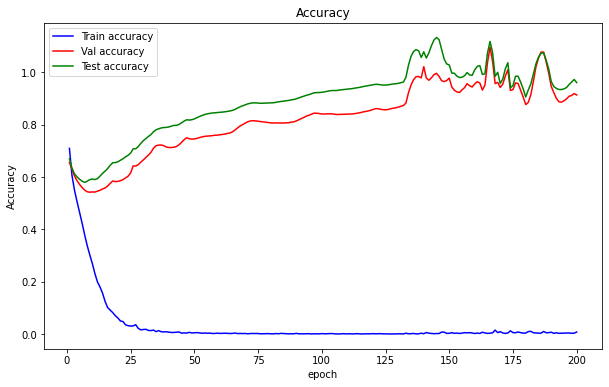

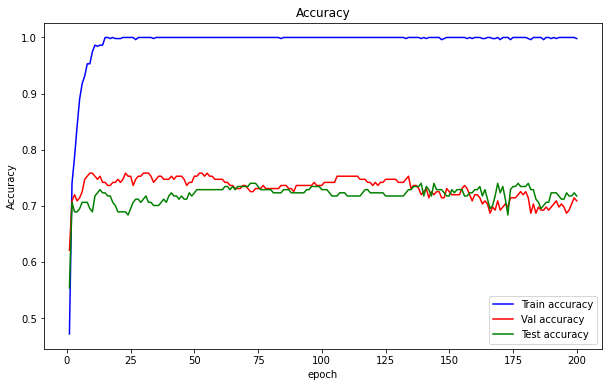



In fold  1
The best validaiton accuracy is:  0.7582417582417582
Happened at epoch:  55
The corresponding test accuracy 0.7288135593220338
The corresponding test AUC is:  0.7781329923273657




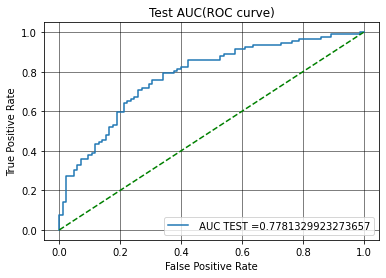

  + Number of params: 2516592
Save models
Train Epoch: 1: train loss : 0.75346071	 train accuracy : 0.47591522	 val accuracy : 0.62711864	 test accuracy : 0.51724138	
Train Epoch: 2: train loss : 0.61331713	 train accuracy : 0.67630058	 val accuracy : 0.56497175	 test accuracy : 0.60344828	
Save models
Train Epoch: 3: train loss : 0.54669893	 train accuracy : 0.77456647	 val accuracy : 0.63841808	 test accuracy : 0.64942529	
Save models
Train Epoch: 4: train loss : 0.48115039	 train accuracy : 0.83236994	 val accuracy : 0.64406780	 test accuracy : 0.64367816	
Save models
Train Epoch: 5: train loss : 0.41805443	 train accuracy : 0.90173410	 val accuracy : 0.66666667	 test accuracy : 0.64367816	
Save models
Train Epoch: 6: train loss : 0.39636004	 train accuracy : 0.90751445	 val accuracy : 0.67231638	 test accuracy : 0.66091954	
Save models
Train Epoch: 7: train loss : 0.37253585	 train accuracy : 0.90173410	 val accuracy : 0.67231638	 test accuracy : 0.65517241	
Train Epoch: 8: train l

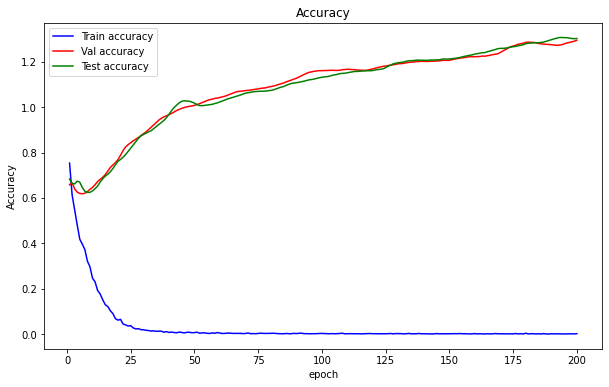

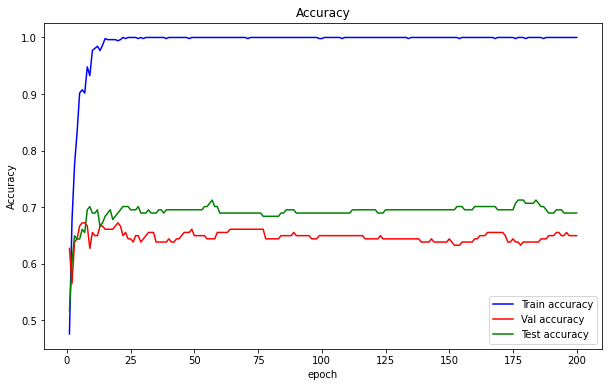



In fold  2
The best validaiton accuracy is:  0.672316384180791
Happened at epoch:  20
The corresponding test accuracy 0.6896551724137931
The corresponding test AUC is:  0.7452542147882649




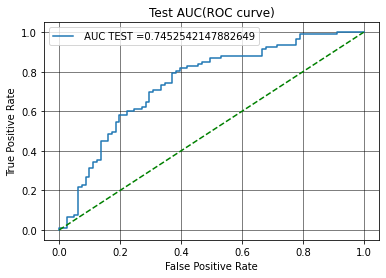

  + Number of params: 2516592
Save models
Train Epoch: 1: train loss : 0.73590493	 train accuracy : 0.47148289	 val accuracy : 0.58620690	 test accuracy : 0.57647059	
Save models
Train Epoch: 2: train loss : 0.59268606	 train accuracy : 0.70912548	 val accuracy : 0.69540230	 test accuracy : 0.67058824	
Train Epoch: 3: train loss : 0.49216905	 train accuracy : 0.80608365	 val accuracy : 0.66091954	 test accuracy : 0.65882353	
Train Epoch: 4: train loss : 0.42499173	 train accuracy : 0.87452471	 val accuracy : 0.67241379	 test accuracy : 0.64117647	
Train Epoch: 5: train loss : 0.37357068	 train accuracy : 0.89353612	 val accuracy : 0.67816092	 test accuracy : 0.63529412	
Save models
Train Epoch: 6: train loss : 0.33177227	 train accuracy : 0.92965779	 val accuracy : 0.71264368	 test accuracy : 0.64705882	
Save models
Train Epoch: 7: train loss : 0.29797530	 train accuracy : 0.93726236	 val accuracy : 0.71264368	 test accuracy : 0.64117647	
Train Epoch: 8: train loss : 0.26866001	 train 

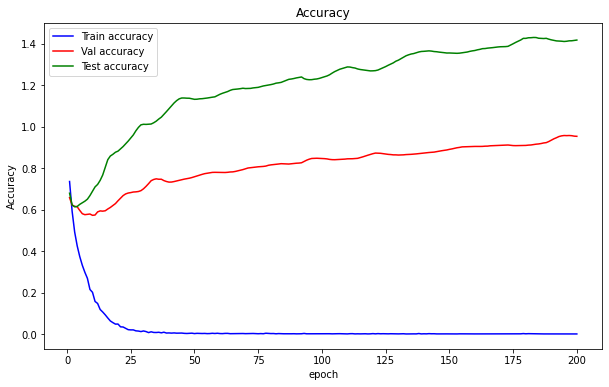

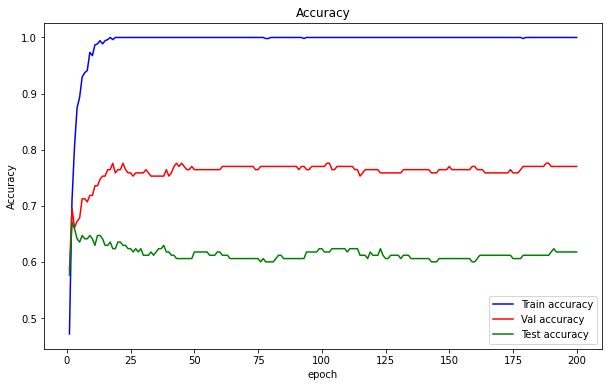



In fold  3
The best validaiton accuracy is:  0.7758620689655172
Happened at epoch:  189
The corresponding test accuracy 0.611764705882353
The corresponding test AUC is:  0.683370660694289




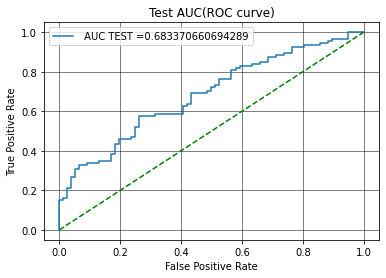

  + Number of params: 2516592
Save models
Train Epoch: 1: train loss : 0.70605981	 train accuracy : 0.51407129	 val accuracy : 0.57647059	 test accuracy : 0.58083832	
Save models
Train Epoch: 2: train loss : 0.59330863	 train accuracy : 0.75797373	 val accuracy : 0.60588235	 test accuracy : 0.64071856	
Train Epoch: 3: train loss : 0.52569050	 train accuracy : 0.83114447	 val accuracy : 0.58235294	 test accuracy : 0.64071856	
Save models
Train Epoch: 4: train loss : 0.47140467	 train accuracy : 0.88555347	 val accuracy : 0.61764706	 test accuracy : 0.64071856	
Save models
Train Epoch: 5: train loss : 0.41808951	 train accuracy : 0.90056285	 val accuracy : 0.64117647	 test accuracy : 0.68862275	
Train Epoch: 6: train loss : 0.36335096	 train accuracy : 0.93621013	 val accuracy : 0.62941176	 test accuracy : 0.69461078	
Train Epoch: 7: train loss : 0.32024261	 train accuracy : 0.96060038	 val accuracy : 0.61764706	 test accuracy : 0.68862275	
Train Epoch: 8: train loss : 0.28078994	 train 

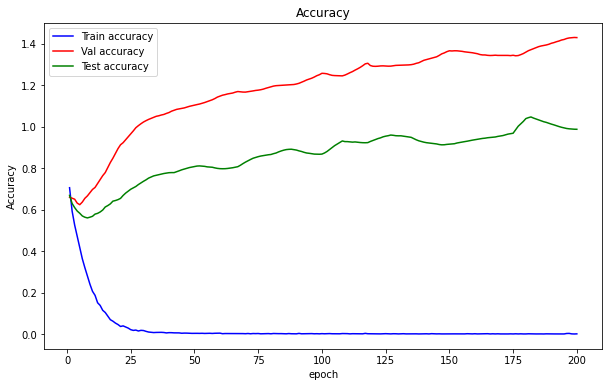

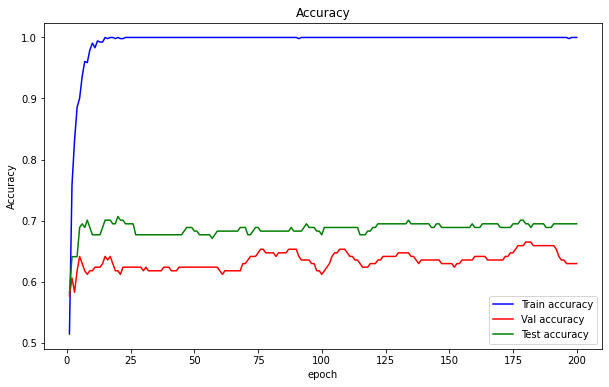



In fold  4
The best validaiton accuracy is:  0.6647058823529411
Happened at epoch:  182
The corresponding test accuracy 0.688622754491018
The corresponding test AUC is:  0.7655072463768117




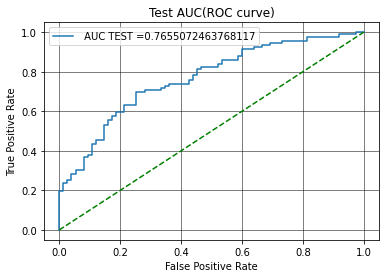

  + Number of params: 2516592
Save models
Train Epoch: 1: train loss : 0.69897258	 train accuracy : 0.48944338	 val accuracy : 0.53892216	 test accuracy : 0.53296703	
Save models
Train Epoch: 2: train loss : 0.62345546	 train accuracy : 0.73512476	 val accuracy : 0.61676647	 test accuracy : 0.65384615	
Save models
Train Epoch: 3: train loss : 0.52926445	 train accuracy : 0.83301344	 val accuracy : 0.64071856	 test accuracy : 0.64835165	
Save models
Train Epoch: 4: train loss : 0.48895049	 train accuracy : 0.83685221	 val accuracy : 0.65269461	 test accuracy : 0.65384615	
Save models
Train Epoch: 5: train loss : 0.41656348	 train accuracy : 0.89443378	 val accuracy : 0.66467066	 test accuracy : 0.68131868	
Train Epoch: 6: train loss : 0.37987620	 train accuracy : 0.90595010	 val accuracy : 0.64670659	 test accuracy : 0.67032967	
Train Epoch: 7: train loss : 0.33255664	 train accuracy : 0.93666027	 val accuracy : 0.65269461	 test accuracy : 0.66483516	
Train Epoch: 8: train loss : 0.2933

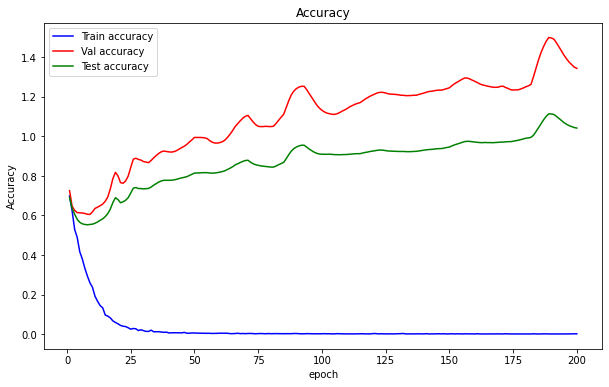

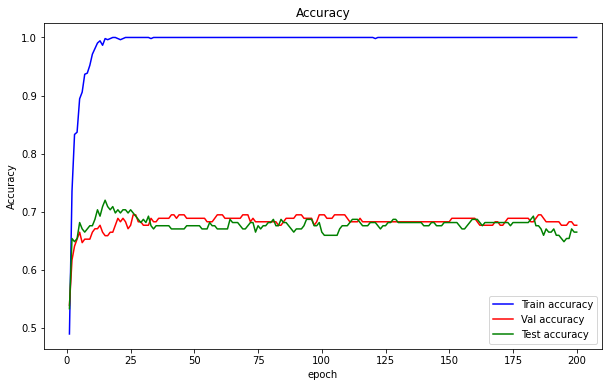



In fold  5
The best validaiton accuracy is:  0.6946107784431138
Happened at epoch:  186
The corresponding test accuracy 0.6703296703296703
The corresponding test AUC is:  0.7523013565891472




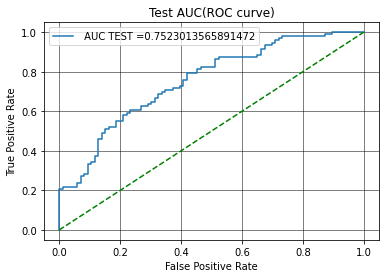

Finish 5-fold training


In [ ]:
########################################### Training ################################################
########################################### Training ################################################
########################################### Training ################################################


for fold in range(1, k_fold+1):
  model = FCN(input_c=args.input_c, hid_1=args.hid_1, hid_2=args.hid_2, out_c=args.out_c, dropout=args.dropout_rate)
  print('  + Number of params: {}'.format(
    sum([p.data.nelement() for p in model.parameters()])))
  model = nn.parallel.DataParallel(model, device_ids=gpu_ids)
  if args.cuda:
    model = model.cuda()
  optimizer = optim.Adam(model.parameters(), lr = args.lr)

  best_validation_accuracy = 0
  Train_accuracy_list =[]
  Train_loss_list = []
  Val_accuracy_list =[]
  Val_loss_list = []
  Test_accuracy_list =[]
  Test_loss_list = []

  for epoch in range(1, args.nEpochs + 1):

    model, train_target, train_out, train_loss, val_target, val_out, val_loss, test_target, test_out, test_prob, test_loss = train(args, model, data[str(fold)], dist_train[str(fold)], dist_validation[str(fold)], dist_test[str(fold)], optimizer)

    train_accuracy = metrics.accuracy_score(train_target, train_out)
    val_accuracy = metrics.accuracy_score(val_target, val_out)
    test_accuracy = metrics.accuracy_score(test_target, test_out)
    Train_accuracy_list.append(train_accuracy)
    Val_accuracy_list.append(val_accuracy)
    Test_accuracy_list.append(test_accuracy)
    Train_loss_list.append(train_loss)
    Val_loss_list.append(val_loss)
    Test_loss_list.append(test_loss)

    if val_accuracy >=best_validation_accuracy:
      best_epoch = epoch
      best_validation_accuracy = val_accuracy
      corresponding_val_out = val_out
      corresponding_test_accuracy = test_accuracy
      corresponding_test_out = test_out
      corresponding_test_prob = test_prob

      print('Save models')
      save_model(model, save_path, 'FCN_'+str(fold))

    print('Train Epoch: ' + str(epoch) + ': train loss : {:.8f}\t train accuracy : {:.8f}\t val accuracy : {:.8f}\t test accuracy : {:.8f}\t'.format(
      train_loss, train_accuracy, val_accuracy, test_accuracy))
  
  if fold == 1:
    all_fold_val_label = val_target
    all_fold_val_out = corresponding_val_out
    all_fold_test_label = test_target
    all_fold_test_out = corresponding_test_out
    all_fold_test_prob = corresponding_test_prob
  else:
    all_fold_val_label = np.concatenate((all_fold_val_label, val_target),axis = 0)
    all_fold_val_out = np.concatenate((all_fold_val_out, corresponding_val_out),axis = 0)
    all_fold_test_label = np.concatenate((all_fold_test_label, test_target),axis = 0)
    all_fold_test_out = np.concatenate((all_fold_test_out, corresponding_test_out),axis = 0)
    all_fold_test_prob = np.concatenate((all_fold_test_prob, corresponding_test_prob),axis = 0)

  x_axis = list(range(1, len(Train_accuracy_list)+1))
  plt.figure(figsize=(10,6))
  plt.plot(x_axis, Train_loss_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_loss_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_loss_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  plt.figure(figsize=(10,6))
  plt.plot(x_axis, Train_accuracy_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_accuracy_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_accuracy_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()


  test_fpr, test_tpr, te_thresholds = roc_curve(test_target, corresponding_test_prob[:,1],pos_label=1)
  test_auc = auc(test_fpr, test_tpr)
  print('\n')
  print('In fold ',str(fold))
  print('The best validaiton accuracy is: ',best_validation_accuracy)
  print('Happened at epoch: ',best_epoch)
  print('The corresponding test accuracy', corresponding_test_accuracy)
  print('The corresponding test AUC is: ',test_auc)
  print('\n')


  plt.grid()
  plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
  plt.plot([0,1],[0,1],'g--')
  plt.legend()
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Test AUC(ROC curve)")
  plt.grid(color='black', linestyle='-', linewidth=0.5)
  plt.show()

print('Finish 5-fold training')




The best validation accuracy is  0.7137931034482758
The corresponding test accuracy is  0.6781609195402298
The corresponding test AUC is:  0.7381257272809391


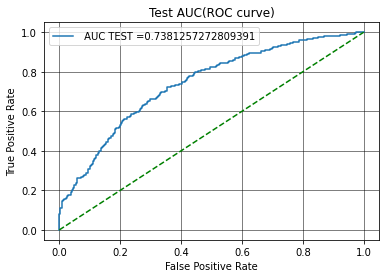

In [ ]:
val_accuracy = metrics.accuracy_score(all_fold_val_label, all_fold_val_out)
test_accuracy = metrics.accuracy_score(all_fold_test_label, all_fold_test_out)
test_fpr, test_tpr, te_thresholds = roc_curve(all_fold_test_label, all_fold_test_prob[:,1],pos_label=1)
test_auc = auc(test_fpr, test_tpr)
print('The best validation accuracy is ',val_accuracy)
print('The corresponding test accuracy is ',test_accuracy)
print('The corresponding test AUC is: ',test_auc)
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

Ensemble  1
Fitting estimator with 19900 features.


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

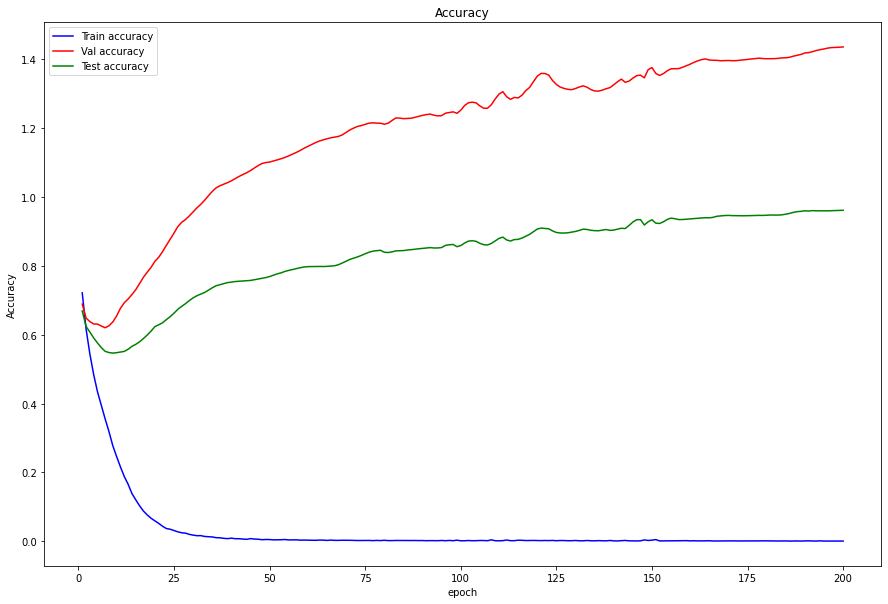

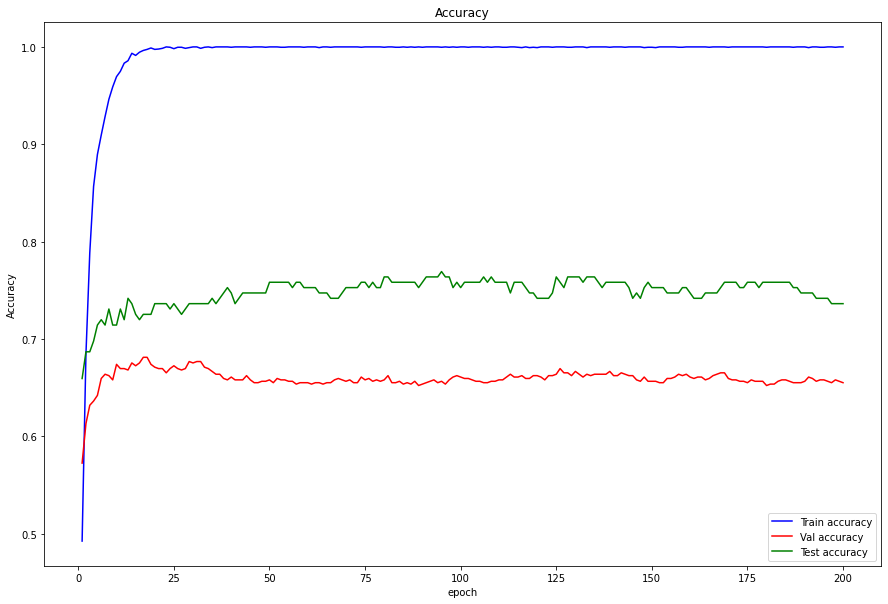



In ensemble  1
The best validaiton accuracy is:  0.6811594202898551
Happened at epoch:  18
The corresponding test accuracy 0.7252747252747253
The corresponding test AUC is:  0.812015503875969




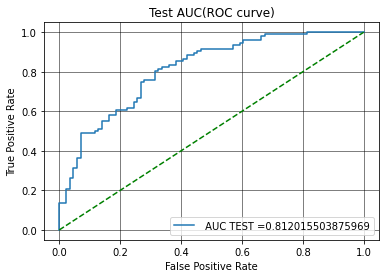



Ensemble  2
Fitting estimator with 19900 features.


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

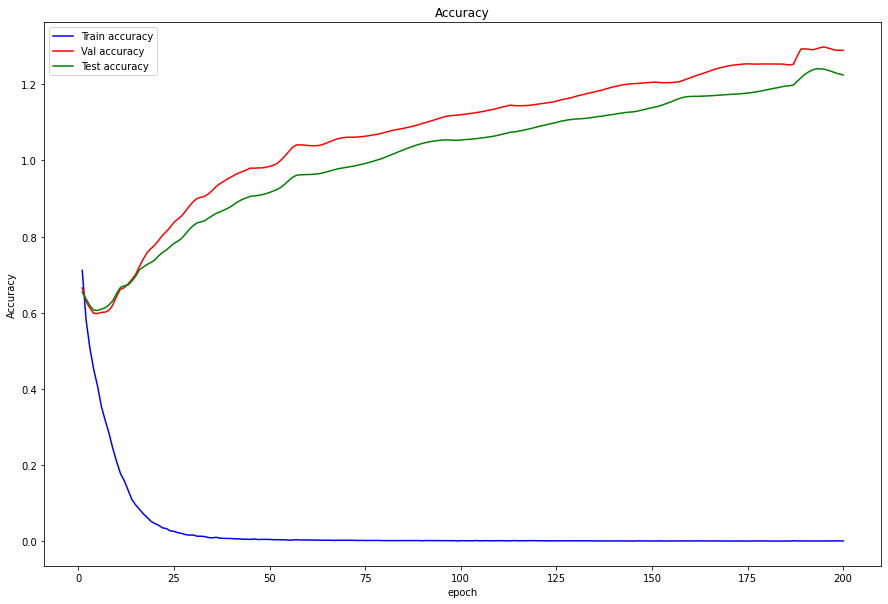

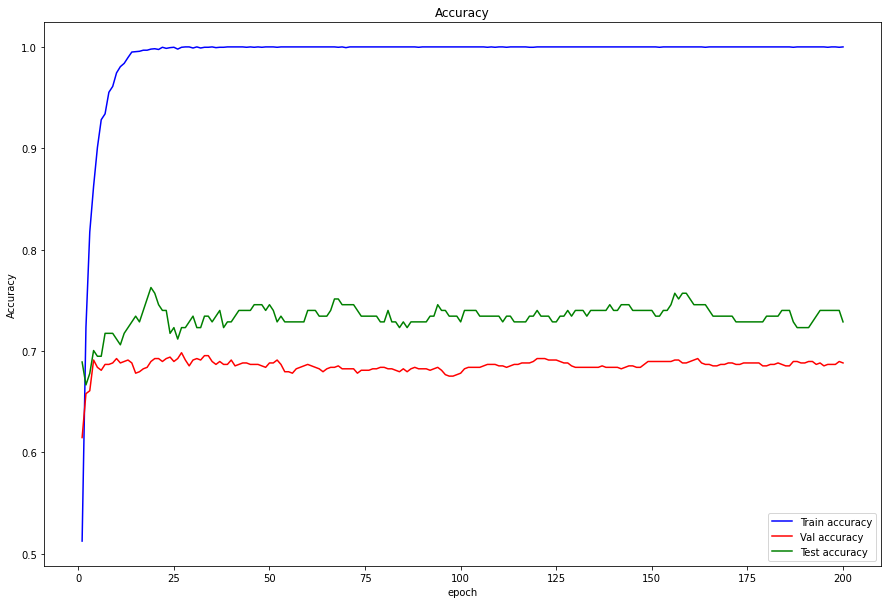



In ensemble  2
The best validaiton accuracy is:  0.6984126984126984
Happened at epoch:  27
The corresponding test accuracy 0.7231638418079096
The corresponding test AUC is:  0.782608695652174




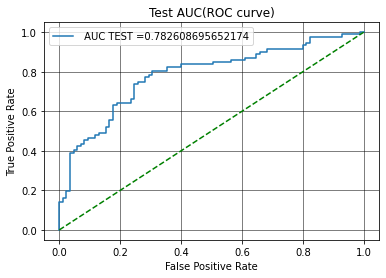



Ensemble  3
Fitting estimator with 19900 features.


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

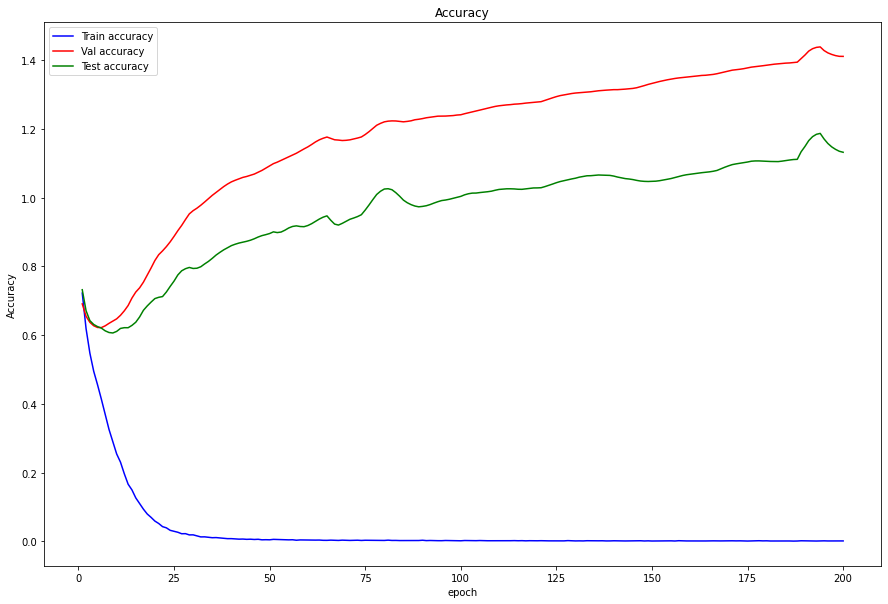

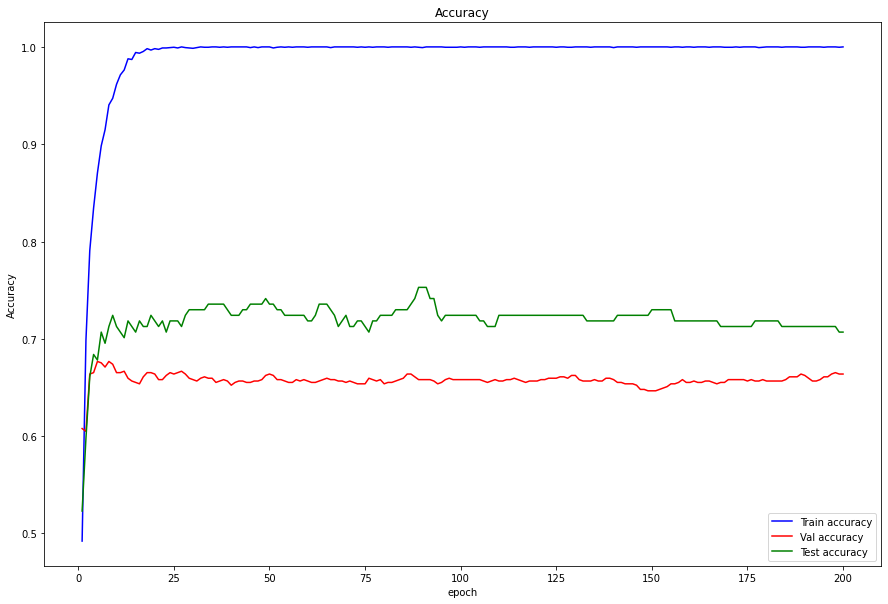



In ensemble  3
The best validaiton accuracy is:  0.6767241379310345
Happened at epoch:  8
The corresponding test accuracy 0.7126436781609196
The corresponding test AUC is:  0.7660958449488917




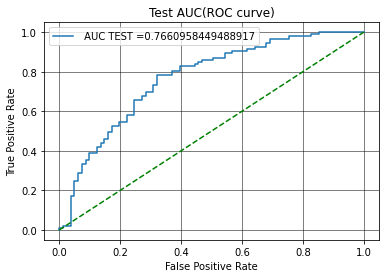



Ensemble  4
Fitting estimator with 19900 features.


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

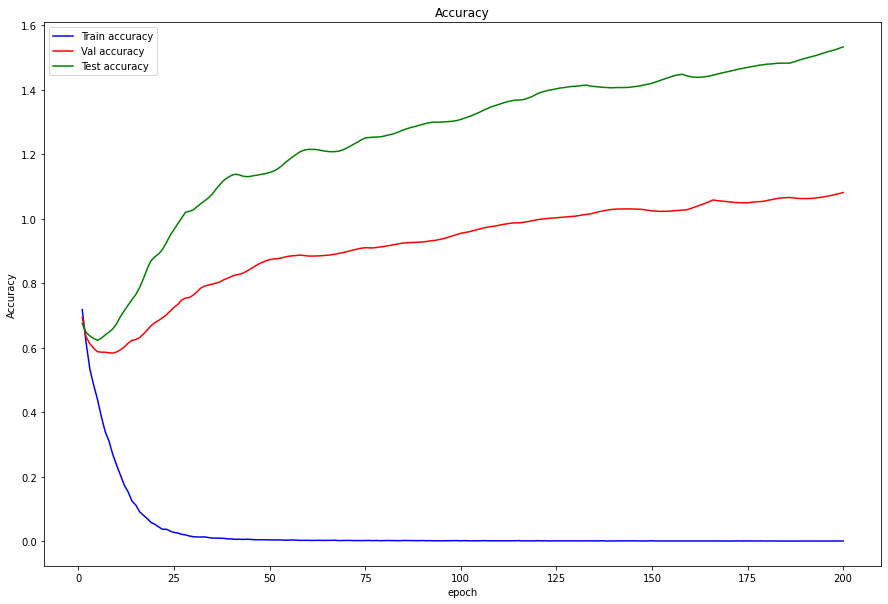

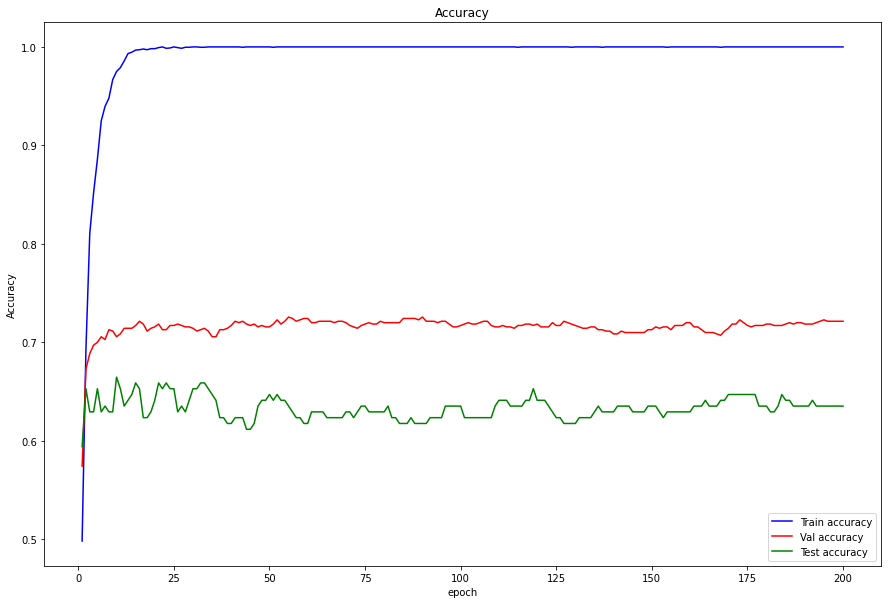



In ensemble  4
The best validaiton accuracy is:  0.7257142857142858
Happened at epoch:  90
The corresponding test accuracy 0.6176470588235294
The corresponding test AUC is:  0.6905095184770438




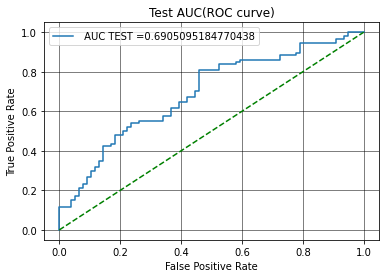



Ensemble  5
Fitting estimator with 19900 features.


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

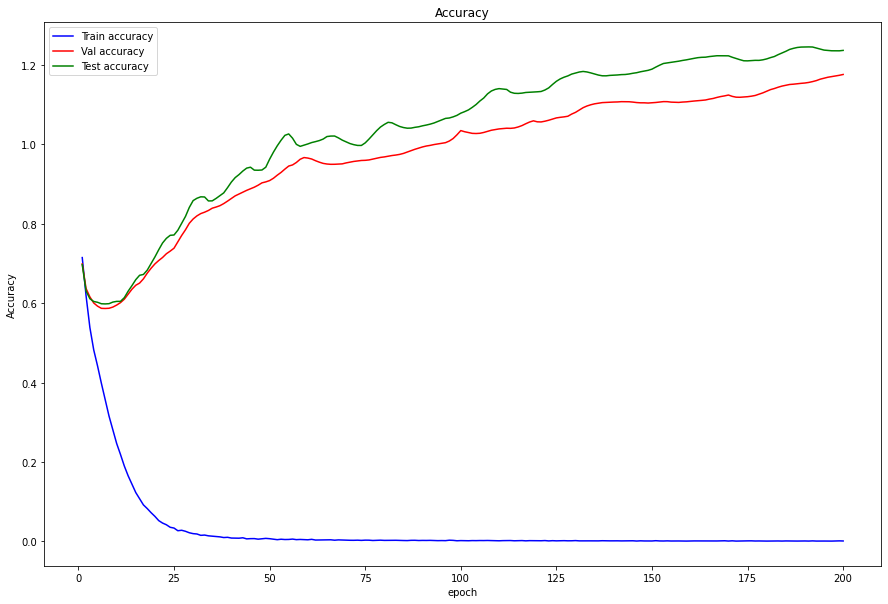

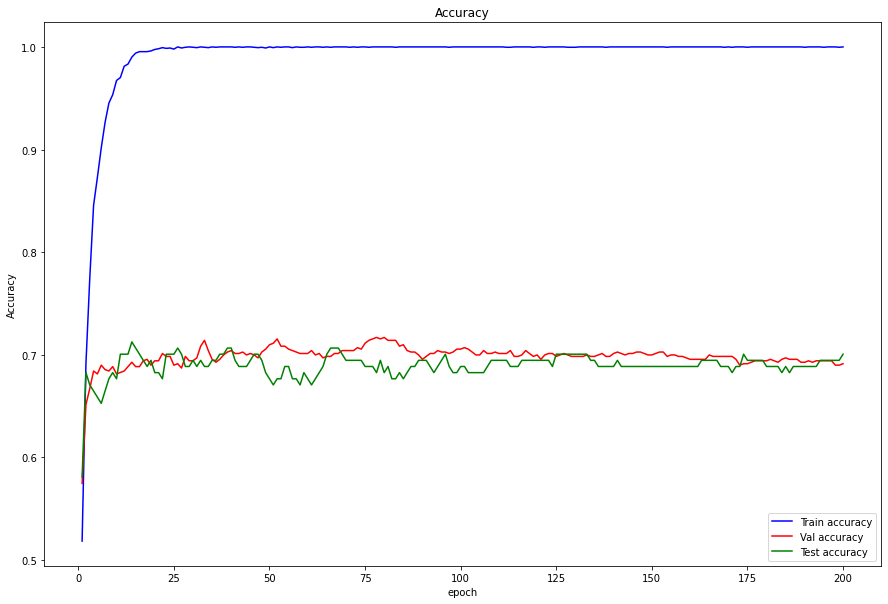



In ensemble  5
The best validaiton accuracy is:  0.716927453769559
Happened at epoch:  80
The corresponding test accuracy 0.6826347305389222
The corresponding test AUC is:  0.7757971014492753




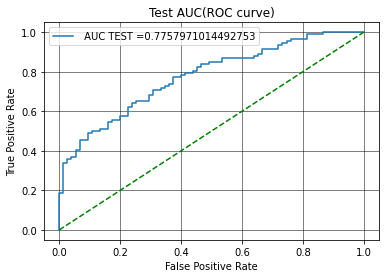



The Max voting test accuracy is:  0.6931034482758621
The test AUC is:  0.7557398738582686






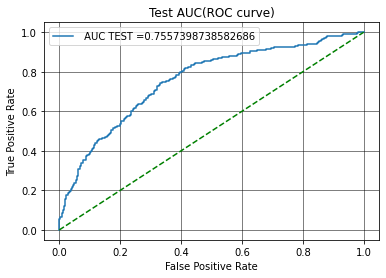

In [ ]:
torch.cuda.empty_cache()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
############################################### Max voting ###############################################################
############################################### Max voting ###############################################################
############################################### Max voting ###############################################################
dist_ensemble_val_label = {}
dist_ensemble_val_result = {}
dist_ensemble_test_label = {}
dist_ensemble_test_result = {}
dist_ensemble_test_prob = {}

for ensemble_fold in range(5):
  print('Ensemble ',ensemble_fold+1)
  save_ensemble_models_path = save_path + 'Max_voting/FCN/'
  dist_train = {}
  dist_validation = {}
  dist_test = {}
  for i in range(k_fold):
    dist_train[str(i + 1)] = []
    dist_validation[str(i + 1)] = []
    dist_test[str(i + 1)] = []
  test_name = {}
  for i in range(len(unique_sites)):
    test_name[unique_sites[i]] = []
  for each_site in unique_sites:
    index_site = get_index(sites, each_site)
    label = np.zeros((len(index_site)))
    for i in range(len(index_site)):
      index = index_site[i]
      label[i] = int(labels[int(index)])
    test_name_list = test_name[each_site]
    ########################################### StratifiedKFold ####################################################
    sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
    group = 0
    for train, validation in sfolder.split(index_site,label):
      if group == ensemble_fold:
        for j in validation:
          name = index_site[j]
          dist_test['1'].append(name)
          dist_test['2'].append(name)
          dist_test['3'].append(name)
          dist_test['4'].append(name)
          dist_test['5'].append(name)
          test_name_list.append(name)
      group = group + 1
    test_name[each_site] = test_name_list

  for each_site in unique_sites:
    if ensemble_fold == 0:

      index_site = get_index(sites, each_site)
      label = np.zeros((len(index_site)))
      for i in range(len(index_site)):
        index = index_site[i]
        label[i] = int(labels[int(index)])
      test_name_list = test_name[each_site]
      index_site_new = []
      label_new = np.zeros((len(index_site) - len(test_name_list)))
      position = 0
      for x in range(len(index_site)):
        sample_name = index_site[x]
        if sample_name in test_name_list:
          c=0
        else:
          index_site_new.append(sample_name)
          label_new[position] = label[x]
          position = position + 1
      if each_site == 'CMU':  # ONLY 4 AUTISM SAMPLES AND 4 TD SAMPLES, CAN NOT BE DEVIDED INTO 5 GROUPS
        group_autism_val = []
        group_autism_train = []
        group_TD_val = []
        group_TD_train = []
        autism_validation_number = len(label_new[label_new ==1])/4
        TD_validation_number = len(label_new[label_new ==0]) / 4
        for j in range(len(label_new)):
          if label_new[j] == 1:
            if len(group_autism_val)<autism_validation_number:
              group_autism_val.append(index_site_new[j])
            else:
              group_autism_train.append(index_site_new[j])
          else:
            if len(group_TD_val)<TD_validation_number:
              group_TD_val.append(index_site_new[j])
            else:
              group_TD_train.append(index_site_new[j])

        dist_validation['1'] = dist_validation['1'] + group_autism_val + group_TD_val
        dist_validation['2'] = dist_validation['2'] + group_autism_val + group_TD_val
        dist_validation['3'] = dist_validation['3'] + group_autism_val + group_TD_val
        dist_validation['4'] = dist_validation['4'] + group_autism_val + group_TD_val
        dist_validation['5'] = dist_validation['5'] + group_autism_val + group_TD_val
        dist_train['1'] = dist_train['1'] + group_autism_train + group_TD_train
        dist_train['2'] = dist_train['2'] + group_autism_train + group_TD_train
        dist_train['3'] = dist_train['3'] + group_autism_train + group_TD_train
        dist_train['4'] = dist_train['4'] + group_autism_train + group_TD_train
        dist_train['5'] = dist_train['5'] + group_autism_train + group_TD_train
      else:
        ########################################### StratifiedKFold ####################################################
        sfolder = StratifiedKFold(n_splits=k_fold, random_state=0, shuffle=True)
        group = 0
        for train, validation in sfolder.split(index_site_new, label_new):

          for i in train:
            name = index_site_new[i]
            dist_train[str(group + 1)].append(name)
          for j in validation:
            name = index_site_new[j]
            dist_validation[str(group + 1)].append(name)
          group = group + 1
    else:

      index_site = get_index(sites, each_site)
      label = np.zeros((len(index_site)))
      for i in range(len(index_site)):
        index = index_site[i]
        label[i] = int(labels[int(index)])
      test_name_list = test_name[each_site]
      index_site_new = []
      label_new = np.zeros((len(index_site) - len(test_name_list)))
      position = 0
      for x in range(len(index_site)):
        sample_name = index_site[x]
        if sample_name in test_name_list:
          c=0
        else:
          index_site_new.append(sample_name)
          label_new[position] = label[x]
          position = position + 1
      ########################################### StratifiedKFold ####################################################
      sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
      group = 0
      for train, validation in sfolder.split(index_site_new,label_new):

        for i in train:
          name = index_site_new[i]
          dist_train[str(group + 1)].append(name)
        for j in validation:
          name = index_site_new[j]
          dist_validation[str(group + 1)].append(name)
        group = group+1
  
  
  data = {}
  for fold in range(1, k_fold+1):
    data[str(fold)] = []
    selector = feature_selection(fMRI_images, labels, dist_train[str(fold)], new_number_features)
    fold_data = selector.transform(fMRI_images)

    data[str(fold)].append(fold_data)
    data[str(fold)].append(FCN_labels)

  ############################################### Train ###############################################################
  ############################################### Train ###############################################################
  ############################################### Train ###############################################################

  model_1 = FCN(input_c=args.input_c, hid_1=args.hid_1, hid_2=args.hid_2, out_c=args.out_c, dropout=args.dropout_rate)
  model_2 = FCN(input_c=args.input_c, hid_1=args.hid_1, hid_2=args.hid_2, out_c=args.out_c, dropout=args.dropout_rate)
  model_3 = FCN(input_c=args.input_c, hid_1=args.hid_1, hid_2=args.hid_2, out_c=args.out_c, dropout=args.dropout_rate)
  model_4 = FCN(input_c=args.input_c, hid_1=args.hid_1, hid_2=args.hid_2, out_c=args.out_c, dropout=args.dropout_rate)
  model_5 = FCN(input_c=args.input_c, hid_1=args.hid_1, hid_2=args.hid_2, out_c=args.out_c, dropout=args.dropout_rate)

  gpu_ids = range(args.ngpu)
  model_1 = nn.parallel.DataParallel(model_1, device_ids=gpu_ids)
  model_2 = nn.parallel.DataParallel(model_2, device_ids=gpu_ids)
  model_3 = nn.parallel.DataParallel(model_3, device_ids=gpu_ids)
  model_4 = nn.parallel.DataParallel(model_4, device_ids=gpu_ids)
  model_5 = nn.parallel.DataParallel(model_5, device_ids=gpu_ids)
  train = train_FCN

  print('  + Number of params: {}'.format(
      sum([p.data.nelement() for p in model_1.parameters()])))
  if args.cuda:
      model_1 = model_1.cuda()
      model_2 = model_2.cuda()
      model_3 = model_3.cuda()
      model_4 = model_4.cuda()
      model_5 = model_5.cuda()

  optimizer_1 = optim.Adam(model_1.parameters(), lr = args.lr)
  optimizer_2 = optim.Adam(model_2.parameters(), lr = args.lr)
  optimizer_3 = optim.Adam(model_3.parameters(), lr = args.lr)
  optimizer_4 = optim.Adam(model_4.parameters(), lr = args.lr)
  optimizer_5 = optim.Adam(model_5.parameters(), lr = args.lr)

  Train_accuracy_list =[]
  Train_loss_list = []
  Val_accuracy_list =[]
  Val_loss_list = []
  Test_accuracy_list =[]
  Test_loss_list = []
  best_validation_accuracy = 0

  for epoch in range(1, args.nEpochs + 1):


    model_1, train_target_1, train_out_1, train_loss_1, val_target_1, val_out_1, val_loss_1, test_target_1, test_out_1, test_prob_1, test_loss_1 = train(args, model_1, data['1'], dist_train['1'], dist_validation['1'], dist_test['1'], optimizer_1)
    model_2, train_target_2, train_out_2, train_loss_2, val_target_2, val_out_2, val_loss_2, test_target_2, test_out_2, test_prob_2, test_loss_2 = train(args, model_2, data['2'], dist_train['2'], dist_validation['2'], dist_test['2'], optimizer_2)
    model_3, train_target_3, train_out_3, train_loss_3, val_target_3, val_out_3, val_loss_3, test_target_3, test_out_3, test_prob_3, test_loss_3 = train(args, model_3, data['3'], dist_train['3'], dist_validation['3'], dist_test['3'], optimizer_3)
    model_4, train_target_4, train_out_4, train_loss_4, val_target_4, val_out_4, val_loss_4, test_target_4, test_out_4, test_prob_4, test_loss_4 = train(args, model_4, data['4'], dist_train['4'], dist_validation['4'], dist_test['4'], optimizer_4)
    model_5, train_target_5, train_out_5, train_loss_5, val_target_5, val_out_5, val_loss_5, test_target_5, test_out_5, test_prob_5, test_loss_5 = train(args, model_5, data['5'], dist_train['5'], dist_validation['5'], dist_test['5'], optimizer_5)

    train_target_all = np.concatenate((train_target_1, train_target_2, train_target_3, train_target_4, train_target_5),axis = 0)
    train_out_all = np.concatenate((train_out_1, train_out_2, train_out_3, train_out_4, train_out_5),axis = 0)
    train_loss = (train_loss_1 + train_loss_2 + train_loss_3 + train_loss_4 + train_loss_5)/5
    val_target_all = np.concatenate((val_target_1, val_target_2, val_target_3, val_target_4, val_target_5),axis = 0)
    val_out_all = np.concatenate((val_out_1, val_out_2, val_out_3, val_out_4, val_out_5),axis = 0)
    val_loss = (val_loss_1 + val_loss_2 + val_loss_3 + val_loss_4 + val_loss_5)/5
    test_target_all = test_target_1 # test_target_1 = test_target_2 = test_target_3 = test_target_4 = test_target_5
    test_out_all = test_out_1 + test_out_2 + test_out_3 + test_out_4 + test_out_5
    test_prob_all = (test_prob_1 + test_prob_2 + test_prob_3 + test_prob_4 + test_prob_5)/5
    test_loss = (test_loss_1 + test_loss_2 + test_loss_3 + test_loss_4 + test_loss_5)/5

    test_results_binary = np.zeros_like((test_out_all))
    test_results_binary[test_out_all<2.5] = 0
    test_results_binary[test_out_all>=2.5] = 1

    train_accuracy = metrics.accuracy_score(train_target_all, train_out_all)
    val_accuracy = metrics.accuracy_score(val_target_all, val_out_all)
    test_accuracy = metrics.accuracy_score(test_target_all, test_results_binary)
    Train_accuracy_list.append(train_accuracy)
    Val_accuracy_list.append(val_accuracy)
    Test_accuracy_list.append(test_accuracy)
    Train_loss_list.append(train_loss)
    Val_loss_list.append(val_loss)
    Test_loss_list.append(test_loss)

    if val_accuracy >=best_validation_accuracy:
      best_epoch = epoch
      best_validation_accuracy = val_accuracy
      corresponding_test_accuracy = test_accuracy
      corresponding_test_prob = test_prob_all
      corresponding_test_labels = test_target_all
      corresponding_test_out = test_results_binary
      print('Save models')

      save_model(model_1, save_ensemble_models_path, 'FCN_ensemble' + str(ensemble_fold) + '_1')
      save_model(model_2, save_ensemble_models_path, 'FCN_ensemble' + str(ensemble_fold) + '_2')
      save_model(model_3, save_ensemble_models_path, 'FCN_ensemble' + str(ensemble_fold) + '_3')
      save_model(model_4, save_ensemble_models_path, 'FCN_ensemble' + str(ensemble_fold) + '_4')
      save_model(model_5, save_ensemble_models_path, 'FCN_ensemble' + str(ensemble_fold) + '_5')

    print('Train Epoch: ' + str(epoch) + ': train loss : {:.8f}\t train accuracy : {:.8f}\t val accuracy : {:.8f}\t test accuracy : {:.8f}\t'.format(
      train_loss, train_accuracy, val_accuracy, test_accuracy))

  x_axis = list(range(1, len(Train_accuracy_list)+1))
  plt.figure(figsize=(15,10))
  plt.plot(x_axis, Train_loss_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_loss_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_loss_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  plt.figure(figsize=(15,10))
  plt.plot(x_axis, Train_accuracy_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_accuracy_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_accuracy_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()
 
  test_fpr, test_tpr, te_thresholds = roc_curve(corresponding_test_labels, corresponding_test_prob[:,1],pos_label=1)
  test_auc = auc(test_fpr, test_tpr)
  print('\n')
  print('In ensemble ',ensemble_fold+1)
  print('The best validaiton accuracy is: ',best_validation_accuracy)
  print('Happened at epoch: ',best_epoch)
  print('The corresponding test accuracy', corresponding_test_accuracy)
  print('The corresponding test AUC is: ',test_auc)
  print('\n')


  plt.grid()
  plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
  plt.plot([0,1],[0,1],'g--')
  plt.legend()
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Test AUC(ROC curve)")
  plt.grid(color='black', linestyle='-', linewidth=0.5)
  plt.show()


  dist_ensemble_test_label[str(ensemble_fold+1)] = corresponding_test_labels
  dist_ensemble_test_result[str(ensemble_fold+1)] = corresponding_test_out
  dist_ensemble_test_prob[str(ensemble_fold+1)] = corresponding_test_prob
  print('\n')

  torch.cuda.empty_cache()

test_labels_concat = np.concatenate((dist_ensemble_test_label['1'], dist_ensemble_test_label['2'],  dist_ensemble_test_label['3'], dist_ensemble_test_label['4'], dist_ensemble_test_label['5']),axis = 0)
test_results_concat = np.concatenate((dist_ensemble_test_result['1'], dist_ensemble_test_result['2'],  dist_ensemble_test_result['3'], dist_ensemble_test_result['4'], dist_ensemble_test_result['5']),axis = 0)
test_probs_concat = np.concatenate((dist_ensemble_test_prob['1'], dist_ensemble_test_prob['2'],  dist_ensemble_test_prob['3'], dist_ensemble_test_prob['4'], dist_ensemble_test_prob['5']),axis = 0)

test_accuracy = metrics.accuracy_score(test_labels_concat, test_results_concat)
test_fpr, test_tpr, te_thresholds = roc_curve(test_labels_concat, test_probs_concat[:,1],pos_label=1)
test_auc = auc(test_fpr, test_tpr)
print('The Max voting test accuracy is: ',test_accuracy)
print('The test AUC is: ',test_auc)

print('\n')
print('\n')
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()



